In [1]:
# run the header that sets up the environment

already_run = globals().get("already_run", False)
if not (already_run):
    already_run = True
    %run header.ipynb

Could not find cannot import name 'dopri5' from 'assimulo.lib' (c:\Users\andre\miniconda3\envs\modelbase.1.30.0\lib\site-packages\assimulo\lib\__init__.py)
Could not find cannot import name 'rodas' from 'assimulo.lib' (c:\Users\andre\miniconda3\envs\modelbase.1.30.0\lib\site-packages\assimulo\lib\__init__.py)
Could not find cannot import name 'odassl' from 'assimulo.lib' (c:\Users\andre\miniconda3\envs\modelbase.1.30.0\lib\site-packages\assimulo\lib\__init__.py)
Could not find ODEPACK functions.
Could not find RADAR5
Could not find GLIMDA.


1.30.0
c:\Users\andre\OneDrive\Bildung\3_HHU\quant_Bio\6th\BA\QTB_modeling\analyses
c:\Users\andre\OneDrive\Bildung\3_HHU\quant_Bio\6th\BA\QTB_modeling


In [2]:
# check implementation of the model

stoichio_subset = m.get_stoichiometric_df().loc[:,["v2_to_P700FA-", "v3_to_P700FA", "v4_to_P700+FA", "v5_to_P700FA", "v3_Mehler", "v4_Mehler"]]
print(stoichio_subset.loc[(stoichio_subset != 0).any(axis=1)])

          v2_to_P700FA-  v3_to_P700FA  v4_to_P700+FA  v5_to_P700FA  v3_Mehler  \
Fd                  0.0          -1.0           -1.0           0.0      0.000   
H2O2                0.0           0.0            0.0           0.0      0.032   
P700+FA-           -1.0           0.0           -1.0           0.0      0.000   
P700FA              0.0           1.0            0.0           1.0      1.000   
P700FA-             1.0          -1.0            0.0           0.0     -1.000   
PC                  1.0           0.0            0.0           1.0      0.000   

          v4_Mehler  
Fd            0.000  
H2O2          0.032  
P700+FA-     -1.000  
P700FA        0.000  
P700FA-       0.000  
PC            0.000  


In [3]:
# set up model with new initial conditions

y0 = {
    "PQ": 11.027139850905353,       "PC": 1.8895071932002812,           "Fd": 3.8690237263896705,
    "ATP": 1.620195002854852,       "NADPH": 0.48821037006737366,       "H": 0.0022147075094596015,
    "LHC": 0.8023074419510501,      "Psbs": 0.9607146039898598,         "Vx": 0.950783616933656,
    "PGA": 0.9913970817549008,      "BPGA": 0.0005355311557548053,      "GAP": 0.0062630116252017295,
    "DHAP": 0.13778623933075737,    "FBP": 0.006126990841013743,        "F6P": 0.31166103888161867,
    "G6P": 0.7168203893211117,      "G1P": 0.041575582577936025,        "SBP": 0.01311315151803723,
    "S7P": 0.15782894767619207,     "E4P": 0.00732079113061801,         "X5P": 0.022396849486562384,
    "R5P": 0.03751472214765548,     "RUBP": 0.13153657267999222,        "RU5P": 0.015005888732707041,
    "MDA": 5.85270097771621e-06,    "ASC": 9.999994138785292,           "H2O2": 3.4273920330125316e-06,
    "DHA": 8.513863740903352e-09,   "GSH": 9.999999991725186,           "GSSG": 4.137406632226743e-09,
    "TR_ox": 0.9,                   "E_inactive": 4.7368421052631575,
    "P700FA": 1.4731,            #eq at pfd 800       #"PSItot": 2.5, (in parameter vector of Matuszynska)
    "P700+FA-": 0.0131,
    "P700FA-": 0.0177,
}

s = Simulator(m)

s.update_parameter("pfd", 800)
s.initialise(y0)
s.simulate_to_steady_state()
y1 = s.get_new_y0()

In [4]:
def simulate_change(s, y0, param, value1, value2, t_to_0, t_after_0):
    """
    Simulate a change in a parameter from value1 to value2, starting at 0. Change appears at "t_to_0".
    """
    #get steady state
    s.update_parameter(param, value1)
    s.initialise(y0)
    s.simulate_to_steady_state()
    y1 = s.get_new_y0()
    if y1 is None:
        # throw error if steady state not reached
        raise ValueError("Modelbase says NO")

    # include some seconds before change
    s.initialise(y1)
    s.simulate(t_to_0)

    # simulate change
    s.update_parameter(param, value2)
    s.simulate(t_after_0)
    
    return None

def plot_change(results_df, t_borders = (0, 75), x_label = "time (s)", y_label = "%", t_dark = [0, 5]):
    """
    Plot the change in a parameter from value1 to value2, starting at 0. Change appears at "t_to_0".
    """
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    for i, label in enumerate(results_df.columns):
        label = results_df.columns[i]
        ax.plot(results_df.index, results_df.loc[:,label], label=label, color = colors[i])

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    ax.axvspan(t_dark[0], t_dark[1], facecolor='grey', alpha=0.5)

    ax.legend(loc="upper right")
    ax.set_xlim(t_borders[0], t_borders[1])

    return fig, ax

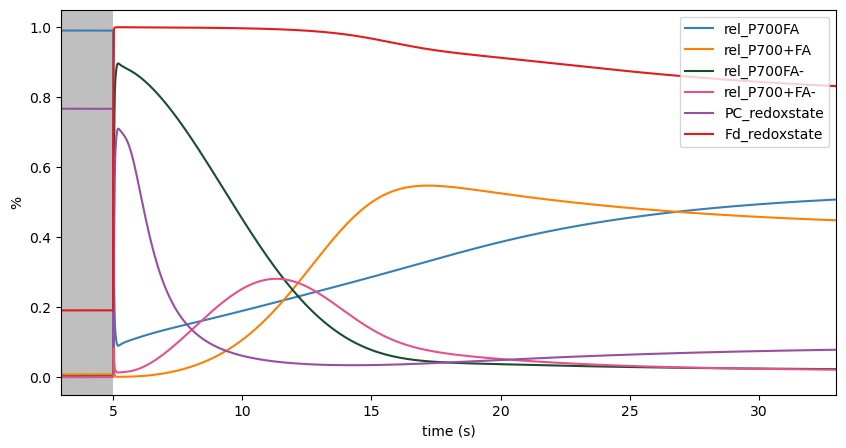

In [5]:
# analysing dark to light transition

pfd_dark = 30
pfd_light = 1000
t_to_0 = 5
t_after_0 = 100
t_borders = [3, 33]

simulate_change(s, y1, "pfd", pfd_dark, pfd_light, t_to_0, t_after_0)

results_df = s.get_full_results_df()

fig,ax = plot_change(results_df = results_df.loc[:, ["rel_P700FA", "rel_P700+FA", "rel_P700FA-", "rel_P700+FA-", "PC_redoxstate", "Fd_redoxstate"]],
                    t_borders = t_borders)
	


In [6]:
folder = "figures/new_model/pfd_dynamics/"
zoom = ""

name = f"PSI_dark_light_{pfd_dark}_{pfd_light}{zoom}"
# eg "200_interval__zoom_600__w_PC_Fd"
os.makedirs(folder, exist_ok=True)
fig.savefig(f"{folder}{name}.png", pad_inches = 0.1, bbox_inches = "tight")

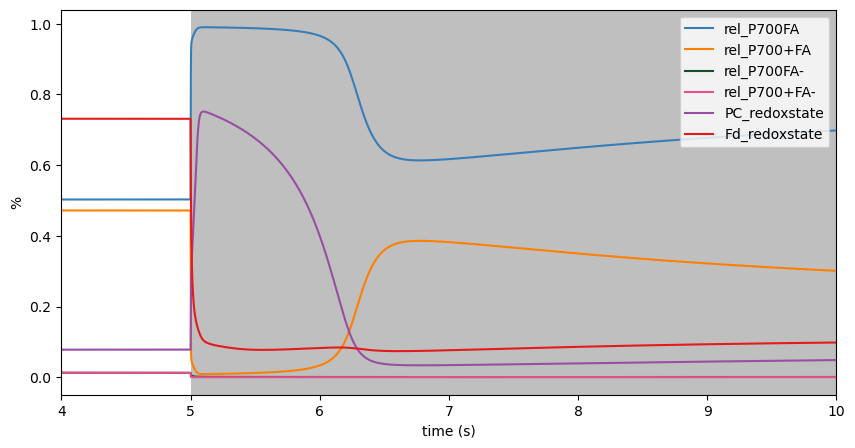

In [7]:
# analysing light to dark transition

pfd_dark = 30
pfd_light = 1000
t_to_0 = 5
t_after_0 = 100
t_borders = [4, 10]

simulate_change(s, y1, "pfd", pfd_light, pfd_dark, t_to_0, t_after_0)

results_df = s.get_full_results_df()

fig,ax = plot_change(results_df = results_df.loc[:, ["rel_P700FA", "rel_P700+FA", "rel_P700FA-", "rel_P700+FA-", "PC_redoxstate", "Fd_redoxstate"]],
                    t_borders= t_borders, t_dark = (t_to_0, t_to_0 + t_after_0))


In [8]:
folder = "figures/new_model/pfd_dynamics/"
zoom = ""

name = f"PSI_light_dark_{pfd_dark}_{pfd_light}{zoom}"
# eg "200_interval__zoom_600__w_PC_Fd"
os.makedirs(folder, exist_ok=True)
fig.savefig(f"{folder}{name}.png", pad_inches = 0.1, bbox_inches = "tight")

In [9]:
dark_intervals = []
interval_length = 200
steps_per_second = 10
pfd_light = 1000
pfd_dark = 40

for i in range(0, 4):
    steps = steps_per_second * interval_length

    if i % 2 == 0: #if i is even
        s.update_parameter("pfd", pfd_dark) #do not set to zero
        dark_intervals.append([i * interval_length, (i + 1) * interval_length])
        print("dark")
    else:
        s.update_parameter("pfd", pfd_light)
        print("light")
    s.simulate(t_end = (i+1) * interval_length, steps = steps)
    print(f"simulated interval {i}")
    print(s.get_full_results_df().shape)

print(dark_intervals)

dark


simulated interval 0
(3464, 73)
light
simulated interval 1
(5464, 73)
dark
simulated interval 2
(7464, 73)
light
simulated interval 3
(9464, 73)
[[0, 200], [400, 600]]


In [10]:
results_df = s.get_full_results_df()
flux_df = s.get_fluxes_df()

#flux_df
#results_df

NameError: name 'fluxes_df' is not defined

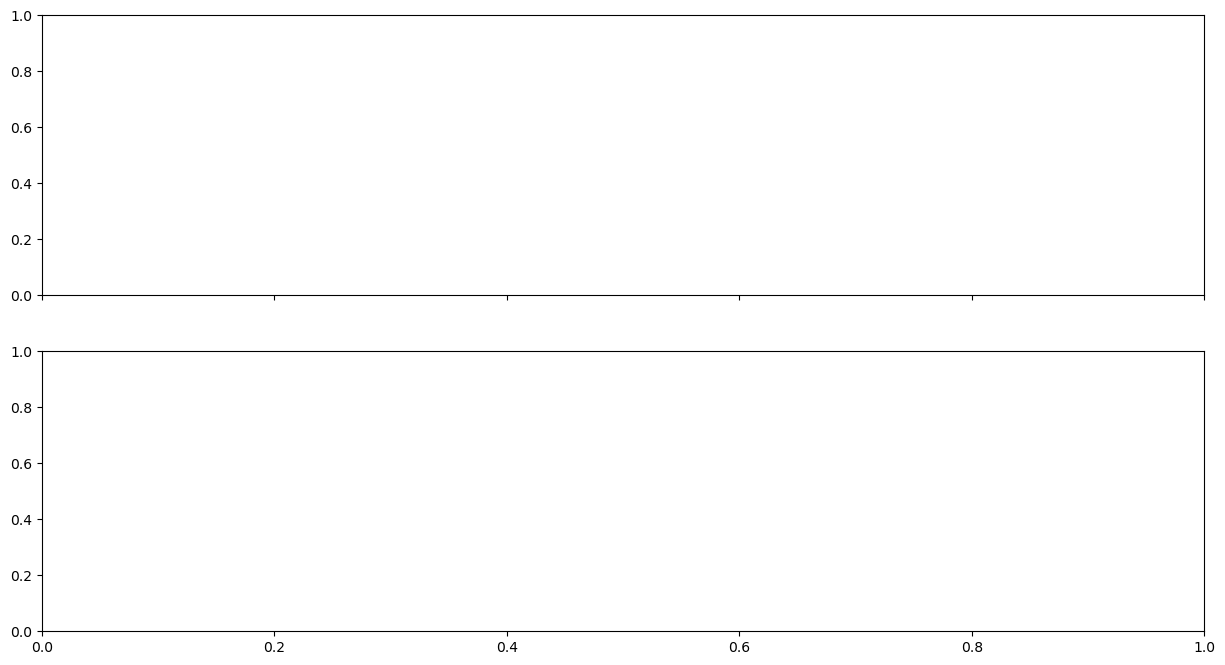

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

results_pdf = results_df.copy()
fluxes_pdf = fluxes_df.copy()

fluxes_pdf.index = fluxes_df.index - 600
results_pdf.index = results_df.index - 600
dark_intervals_p = [[i - 600 for i in interval] for interval in dark_intervals]

ax[0].plot(results_pdf.index, results_pdf["rel_P700FA"  ], label="P700FA"  , color = colors[0])
ax[0].plot(results_pdf.index, results_pdf["rel_P700+FA" ], label="P700+FA" , color = colors[1])
ax[0].plot(results_pdf.index, results_pdf["rel_P700FA-" ], label="P700FA-" , color = colors[2])
ax[0].plot(results_pdf.index, results_pdf["rel_P700+FA-"], label="P700+FA-", color = colors[3])
ax[0].plot(results_pdf.index, results_pdf["PC_redoxstate"], label="%PC_red", color = colors[4])
ax[0].plot(results_pdf.index, results_pdf["Fd_redoxstate"], label="%Fd_red", color = colors[5])
ax[0].legend(loc="upper right")

ax[1].plot(fluxes_pdf.index, fluxes_pdf["vPS1"], label="vPS1", color = colors[0])
ax[1].plot(fluxes_pdf.index, fluxes_pdf["v2_to_P700FA-"], label="v2_to_P700FA-", color = colors[1])
ax[1].plot(fluxes_pdf.index, fluxes_pdf["v3_to_P700FA"], label="v3_to_P700FA",   color = colors[2])
ax[1].plot(fluxes_pdf.index, fluxes_pdf["v4_to_P700+FA"], label="v4_to_P700+FA", color = colors[3])
ax[1].plot(fluxes_pdf.index, fluxes_pdf["v5_to_P700FA"], label="v5_to_P700FA",   color = colors[4])
ax[1].set_yscale("log")
ax[1].legend(loc="upper right")


for period in dark_intervals_p:
    for i, _ in enumerate(ax):
        ax[i].axvspan(period[0], period[1], facecolor='grey', alpha=0.5)

for i, _ in enumerate(ax):
    #ax[i].set_xlim(-0.01, 0.5)
    ax[i].grid(alpha = 0.5)


#ax[0].set_xscale("symlog", base=10)
#ax[i].set_xlim(-.1, 200)
#ax[1].set_xscale("symlog")

fig.show()

In [ ]:
folder = "figures/playground/new_model/PS1_states/"
#name = input("Enter the name of the file: ")
zoom = "600broad"
#zoom = "broadview"

name = f"pfd_{pfd_dark}_{pfd_light}__interval_{interval_length}__zoom_{zoom}"
# eg "200_interval__zoom_600__w_PC_Fd"
os.makedirs(folder, exist_ok=True)
fig.savefig(f"{folder}{name}.png", pad_inches = 0.1, bbox_inches = "tight")

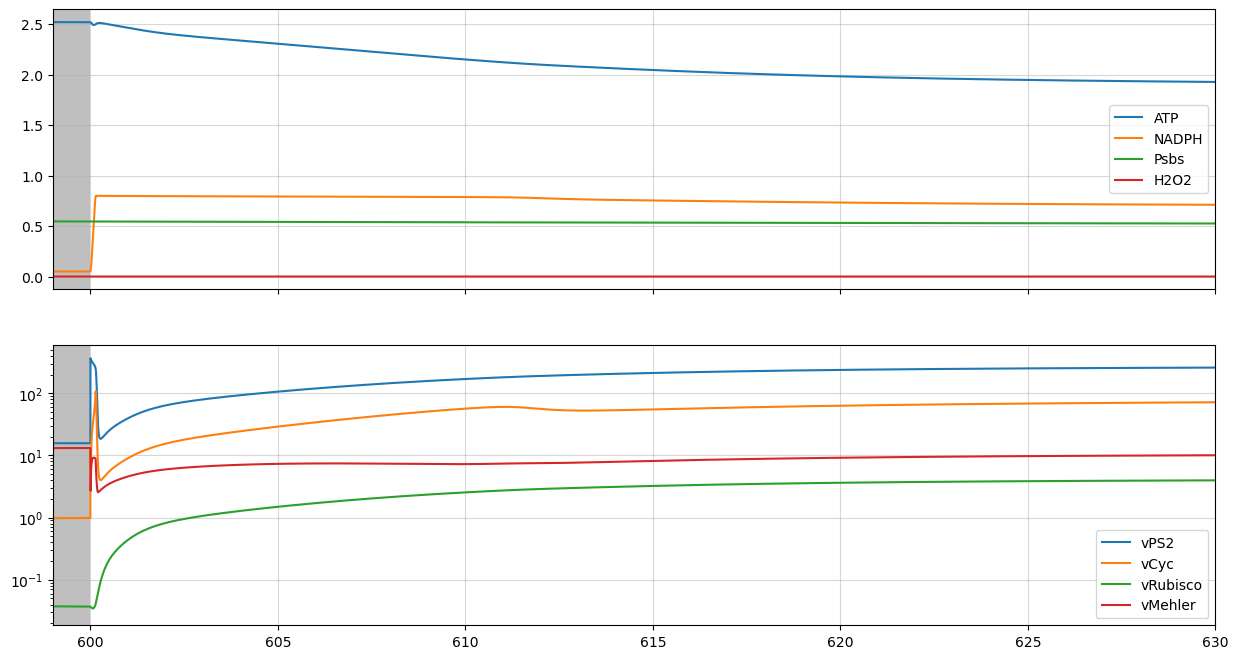

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
ax[0].plot(results_df.index, results_df["ATP"], label="ATP")
ax[0].plot(results_df.index, results_df["NADPH"], label="NADPH")
ax[0].plot(results_df.index, results_df["Psbs"], label="Psbs")
ax[0].plot(results_df.index, results_df["H2O2"], label="H2O2")
ax[0].legend()

ax[1].plot(flux_df.index, flux_df["vPS2"], label="vPS2")
ax[1].plot(flux_df.index, flux_df["vCyc"], label="vCyc")
ax[1].plot(flux_df.index, flux_df["vRuBisCO"], label="vRubisco")
ax[1].plot(flux_df.index, flux_df["vMehler"], label="vMehler")
ax[1].legend()
ax[1].set_yscale("log")


for period in dark_intervals:
    for i, _ in enumerate(ax):
        ax[i].axvspan(period[0], period[1], facecolor='grey', alpha=0.5)

for i, _ in enumerate(ax):
    ax[i].set_xlim(599, 630)
    ax[i].grid(alpha = 0.5)
fig.show()

In [ ]:
folder = "figures/playground/new_model/general/"
#name = input("Enter the name of the file: ")
# eg "200_interval__zoom_600__w_PC_Fd"

zoom = "600broad"
#zoom = "broadview"

name = f"pfd_{pfd_dark}_{pfd_light}__interval_{interval_length}__zoom_{zoom}"

os.makedirs(folder, exist_ok=True)
fig.savefig(f"{folder}{name}.png", pad_inches = 0.1, bbox_inches = "tight")